In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
perf_train= pd.read_csv('trainperf.csv')
perf_test= pd.read_csv('testperf.csv')

In [108]:
demo_train= pd.read_csv('traindemographics.csv')
demo_test= pd.read_csv('testdemographics.csv')

In [109]:
prev_train= pd.read_csv('trainprevloans.csv')
prev_test= pd.read_csv('testprevloans.csv')

In [110]:
perf_demo_train=demo_train.merge(perf_train, on='customerid', how='right')
perf_demo_test= demo_test.merge(perf_test, on='customerid', how='right')

In [111]:
perf_demo_train['num_null']=perf_demo_train.isnull().sum(axis=1).values
perf_demo_test['num_null']=perf_demo_test.isnull().sum(axis=1).values

In [112]:
perf_train=perf_demo_train[['num_null', 'customerid']].merge(perf_train, on='customerid', how='right')
perf_test= perf_demo_test[['num_null', 'customerid']].merge(perf_test, on='customerid', how='right')

In [113]:
perf_train['referredby']= perf_train['referredby'].fillna(value='no one')

perf_test['referredby']= perf_test['referredby'].fillna(value='no one')

In [114]:
def days(row):
    row= str(row)
    return int(row[:row.index(' ')])

In [115]:
def pay_rate(df):
    day= (pd.to_datetime(df['closeddate'])-pd.to_datetime(df['approveddate'])).apply(days)
    return df['totaldue']/day

In [116]:
prev_train['pay_rate']= pay_rate(prev_train)
prev_test['pay_rate']= pay_rate(prev_test)

In [117]:
perf_train=perf_train.merge(prev_train[['customerid', 'loanamount']].groupby(by='customerid', as_index=False).sum(), on='customerid', how='left')
perf_test=perf_test.merge(prev_test[['customerid', 'loanamount']].groupby(by='customerid', as_index=False).sum(), on='customerid', how='left')

In [118]:
perf_train['loanamount_y'].fillna(value=0, inplace=True)
perf_test['loanamount_y'].fillna(value=0, inplace=True)

In [119]:
avg_train=prev_train[['customerid', 'pay_rate']].groupby(by='customerid', as_index=False).mean()
avg_test=prev_test[['customerid', 'pay_rate']].groupby(by='customerid', as_index=False).mean()

In [120]:
perf_train= perf_train.merge(avg_train, on='customerid', how='left')
perf_test= perf_test.merge(avg_test, on='customerid', how='left')

In [121]:
perf_train['pay_rate'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
perf_test['pay_rate'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [122]:

perf_train=perf_train.merge(demo_train[['customerid', 'bank_account_type','employment_status_clients', 'level_of_education_clients']], on='customerid', how='left')

perf_test=perf_test.merge(demo_test[['customerid', 'bank_account_type','employment_status_clients', 'level_of_education_clients']], on='customerid', how='left')

In [123]:
perf_train.fillna(value='null', inplace=True)

perf_test.fillna(value='null', inplace=True)

In [124]:
useless= ['customerid','systemloanid', 'approveddate', 'creationdate']
perf_train.drop(useless, axis=1, inplace=True)
perf_test.drop(useless, axis=1, inplace=True)

In [125]:
X= perf_train.drop(['good_bad_flag'], axis=1)
Y= perf_train['good_bad_flag']

In [126]:
X

,num_null,loannumber,loanamount_x,totaldue,termdays,referredby,loanamount_y,pay_rate,bank_account_type,employment_status_clients,level_of_education_clients
0,2,12,30000.0,34500.0,30,no one,200000.0,2988.835851,Other,Permanent,Post-Graduate
1,1,2,15000.0,17250.0,30,no one,0.0,0.000000,Savings,Permanent,Graduate
2,3,7,20000.0,22250.0,15,no one,60000.0,1105.846561,Other,Permanent,null
3,3,3,10000.0,11500.0,15,no one,20000.0,393.518519,Savings,Permanent,null
4,2,9,40000.0,44000.0,30,no one,150000.0,850.269865,Other,Permanent,Primary
...,...,...,...,...,...,...,...,...,...,...,...
4387,9,2,10000.0,13000.0,30,no one,10000.0,361.111111,null,null,null
4388,3,2,10000.0,13000.0,30,no one,10000.0,500.000000,Savings,Permanent,null
4389,3,3,10000.0,11500.0,15,no one,20000.0,596.198157,Savings,Permanent,null
4390,2,2,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,10000.0,433.333333,Savings,Permanent,null


In [47]:
from sklearn.model_selection import train_test_split

In [48]:
x_train,x_test ,y_train, y_test= train_test_split(X,Y, test_size=0.1, random_state=0)

In [49]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)



In [50]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_preprocessor = RobustScaler()


categorical_preprocessor= OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ('ordinal-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

C:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [51]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import SCORERS
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [52]:
def crs_val(algo):
  # run block of code and catch warnings
  import warnings
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    cv= StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2)
    model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42)), ('model', algo)])
    result= cross_validate(model, x_train, y_train, cv=cv, scoring='accuracy', return_train_score=False)
    #print(result)
    return result['test_score']

In [53]:
algos= {'LogisticRegression':LogisticRegression(max_iter=2000),
       'RandomForestClassifier': RandomForestClassifier(random_state=0),
       'LGBMClassifier': LGBMClassifier(random_state=0)
       }
for alg in algos.keys():
    score= crs_val(algos[alg])
    print(alg+': \n',score.mean(), ' +/- ',score.std())

LogisticRegression: 
 0.5863463969658659  +/-  0.021453077365678627
RandomForestClassifier: 
 0.6962073324905184  +/-  0.01550464661399947
LGBMClassifier: 
 0.7217446270543616  +/-  0.015027240224439997


In [ ]:
"""LogisticRegression: 
 0.5809644670050761  +/-  0.012788957042988965
RandomForestClassifier: 
 0.7032994923857868  +/-  0.01461100300977084
LGBMClassifier: 
 0.7224619289340102  +/-  0.012779509167797316
"""

In [83]:
from scipy.stats import loguniform
from math import ceil

class loguniform_odd_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a//2, b//2)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return -1+ (2*self._distribution.rvs(*args, **kwargs).astype(int))
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [93]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42 )), ('classifier', LGBMClassifier(random_state=0, n_jobs=-1))])
cv= StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.22)
param_grid = {
    'classifier__n_estimators': loguniform_int(100,500),
    'classifier__reg_alpha': loguniform(0.0001, 1),
    'classifier__reg_lambda': loguniform(0.0001, 1),
    'sample__k_neighbors':loguniform_odd_int(30, 50)
   
}
model_grid_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_jobs=-1, cv=cv, n_iter=20, random_state=0
)
model_grid_search.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.22,
            train_size=None),
                   estimator=Pipeline(steps=[('scale',
                                              ColumnTransformer(transformers=[('ordinal-encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['referredby',
                                                                                'bank_account_type',
                                                                                'employment_status_clients',
                                                                                'level_of_education_clients']),
                                                                              ('standard-scaler',
                                                                               RobustSc...
  

In [96]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__n_estimators",
    "param_sample__k_neighbors",
    'param_classifier__reg_lambda',
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__n_estimators,param_sample__k_neighbors,param_classifier__reg_lambda,mean_test_score,std_test_score,rank_test_score
0,241,37,0.025766,0.746897,0.006718,11
1,197,45,0.005628,0.747586,0.008033,9
2,471,37,0.146859,0.740345,0.009664,17
3,249,29,0.000192,0.745172,0.008257,13
4,103,45,0.129607,0.754483,0.010180,2
5,483,43,0.007013,0.737126,0.009995,18
6,120,47,0.000374,0.755287,0.011591,1
7,231,43,0.001143,0.750690,0.007938,4
8,208,39,0.000119,0.747356,0.007860,10
9,267,41,0.595652,0.749885,0.009688,5


In [92]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__n_estimators",
    "param_sample__k_neighbors",
    'param_classifier__reg_alpha',
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__n_estimators,param_sample__k_neighbors,param_classifier__reg_alpha,mean_test_score,std_test_score,rank_test_score
0,241,39,0.07257,0.747126,0.009324,9
1,240,39,0.00495,0.742184,0.006644,17
2,202,47,0.369056,0.750920,0.009604,6
3,185,37,0.146859,0.754023,0.006296,2
4,249,29,0.503949,0.745172,0.007325,12
5,115,43,0.00012,0.758506,0.007786,1
6,349,47,0.302029,0.743563,0.006848,16
7,361,43,0.007013,0.741034,0.008904,19
8,120,31,0.036281,0.752644,0.009193,5
9,457,35,0.012229,0.737356,0.009412,20


In [97]:
model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42 )), ('classifier', LGBMClassifier(random_state=0, n_jobs=-1))])

model_grid_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_jobs=-1, cv=cv, n_iter=20, random_state=0
)

cv_results = cross_validate(
    model_grid_search, X, Y, cv=cv, n_jobs=-1, return_estimator=True
)

In [98]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.756 +/- 0.015


In [99]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__n_estimators': 103, 'classifier__reg_alpha': 0.2140323314098605, 'classifier__reg_lambda': 0.1296065659727972, 'sample__k_neighbors': 45}
Best hyperparameters for fold #2:
{'classifier__n_estimators': 103, 'classifier__reg_alpha': 0.2140323314098605, 'classifier__reg_lambda': 0.1296065659727972, 'sample__k_neighbors': 45}
Best hyperparameters for fold #3:
{'classifier__n_estimators': 103, 'classifier__reg_alpha': 0.2140323314098605, 'classifier__reg_lambda': 0.1296065659727972, 'sample__k_neighbors': 45}
Best hyperparameters for fold #4:
{'classifier__n_estimators': 120, 'classifier__reg_alpha': 0.036281404040243784, 'classifier__reg_lambda': 0.00037446665357415655, 'sample__k_neighbors': 47}
Best hyperparameters for fold #5:
{'classifier__n_estimators': 103, 'classifier__reg_alpha': 0.2140323314098605, 'classifier__reg_lambda': 0.1296065659727972, 'sample__k_neighbors': 45}
Best hyperparameters for fold #6:
{'classifier__n_estimators': 1

In [100]:
models=cv_results.sort_values(by='test_score', ascending=False)
models

,fit_time,score_time,estimator,test_score
8,151.761483,0.053007,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.783868
4,49009.322423,0.105007,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.771458
2,348.902450,0.133001,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.767322
5,49009.155900,0.158073,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.763185
7,49006.154788,0.086531,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.754912
3,347.883599,0.124008,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.752844
1,345.668811,0.176997,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.747673
0,349.017456,0.129999,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.740434
6,49005.517532,0.081984,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.740434
9,150.471961,0.057994,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.737332


In [138]:
predictions={}
i=0
for model in models["estimator"]:
    predictions[str(i)]=model.predict(perf_test)

    i +=1
    if i == 5:
        break

In [152]:
pred=pd.DataFrame(predictions).mode(axis=1).values

(array([1260.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         190.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

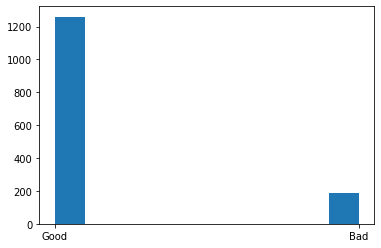

In [153]:
plt.hist(pred)

<AxesSubplot:>

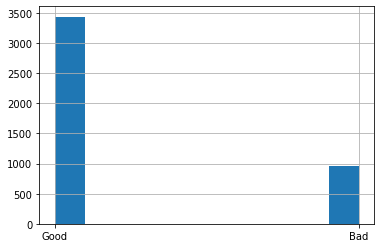

In [148]:
Y.hist()

In [154]:
def submit():
    import datetime
    sub= pd.read_csv('SampleSubmission.csv')
    sub['good_bad_flag']=OrdinalEncoder().fit_transform(pred.reshape(-1,1))
    moment=datetime.datetime.now().strftime('%m%d%H%M%S')
    #print(moment)
    sub.to_csv(moment+'.csv', index=False)
    print(moment)
submit()

0324174449
